# Finalising the Data - 10-07-19

Importing census data and ironing out the dependent variable

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium 
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats


In [2]:
master_df = pd.read_csv("agg_census.csv", index_col=0)
master_df.head()

,STCOU,patent_output,total_cited_by,avg_cit_pp,Area_name,total_pop,pop_psqm,pct_2races
0,6085,13755,28775,2.091967,"Santa Clara, CA",1781642.0,1381.0,4.9
1,6037,5907,10176,1.722702,"Los Angeles, CA",9818605.0,2419.6,4.5
2,6073,5445,9663,1.774656,"San Diego, CA",3095313.0,735.8,5.1
3,53033,4325,9820,2.270520,"King, WA",1931249.0,912.9,5.0
4,6059,4007,9045,2.257300,"Orange, CA",3010232.0,3807.7,4.2


## Dependent Variable

- Citations average take the median (what about 0)
- Calculate rate of patent increase

In [3]:
#Aim to find the median ctations opposed to mean
imported_df = pd.read_csv("first_census_patent.csv", index_col=0)
median_df = imported_df.groupby(['STCOU']).median()
median_df2 = median_df[['it_cited', 'cited_by']]
median_df2 = median_df2.rename(columns={'it_cited': 'it_cited_median', 'cited_by': 'cited_by_median'})

median_df2.head()

,it_cited_median,cited_by_median
STCOU,,
1001,5.5,0.0
1003,9.0,0.0
1005,27.0,1.0
1007,3.0,0.0
1009,13.0,0.0


In [4]:
#Descriptive Stats for number of patents it cited
median_df2['it_cited_median'].describe().apply(lambda x: format(x, 'f'))

count    2382.000000
mean       13.708438
std        14.480494
min         0.000000
25%         7.500000
50%        11.000000
75%        15.500000
max       259.000000
Name: it_cited_median, dtype: object

In [5]:
#Descriptive Stats for number of patents it is cited by
median_df2['cited_by_median'].describe().apply(lambda x: format(x, 'f'))

count    2382.000000
mean        0.591940
std         1.466891
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        29.000000
Name: cited_by_median, dtype: object

(0, 30)

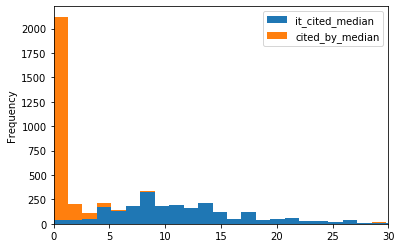

In [6]:
median_df2.plot.hist(stacked=True, bins=200)
plt.xlim(0,30)


Finding the mean of the top quaterile of cited_by. The citations tend to have a long tail, meaning there are a lot of 0 values. We overcome this by taking the top 90% percentile. 0 values are acheived when all patents have been cited 0 times.

County: 6001
90th percentile: 4.0
95th percentile: 5.0


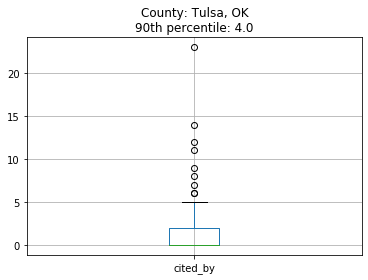

In [7]:
imported_df['date'] = imported_df['date'].str[:4]
random_county = int(imported_df.sample()['STCOU'])#provides random county number (34013 good example)
sample_median_df = imported_df.loc[imported_df['STCOU'] == 40143]

print(f'County: {random_county}')

print(f'90th percentile: {sample_median_df.quantile(0.9).values[2]}')
print(f'95th percentile: {sample_median_df.quantile(.95).values[2]}')

plt.title(f"""County: Tulsa, OK
90th percentile: {sample_median_df.quantile(0.9).values[2]}""")
sample_median_df.boxplot(column=['cited_by'])

In [8]:
def top_percentile(x):
    '''takes in a df, returns the top percentile value'''
    percentile = x.quantile(0.9).values[2]
    #print(x.iloc[0,17], f': {percentile}') #prints output of the function
    return (percentile)

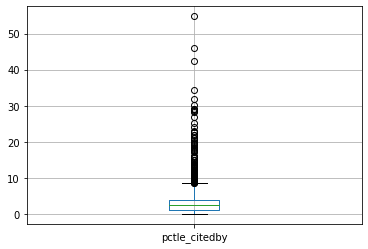

In [9]:
#run through the df and apply the df function
cited_group = imported_df.groupby(['STCOU']).apply(top_percentile).to_frame().reset_index().rename(columns={0: 'pctle_citedby'})

#Plot the boxplot for the cited by values
cited_group.boxplot(column=['pctle_citedby'])

In [10]:
#Join to main dataframe
master_df = pd.merge(master_df, cited_group, on = 'STCOU',  how='outer')
master_df.head()

,STCOU,patent_output,total_cited_by,avg_cit_pp,Area_name,total_pop,pop_psqm,pct_2races,pctle_citedby
0,6085,13755,28775,2.091967,"Santa Clara, CA",1781642.0,1381.0,4.9,5.0
1,6037,5907,10176,1.722702,"Los Angeles, CA",9818605.0,2419.6,4.5,4.0
2,6073,5445,9663,1.774656,"San Diego, CA",3095313.0,735.8,5.1,4.0
3,53033,4325,9820,2.270520,"King, WA",1931249.0,912.9,5.0,6.0
4,6059,4007,9045,2.257300,"Orange, CA",3010232.0,3807.7,4.2,5.0


In [11]:
#Join to main data
master_df = pd.merge(master_df, median_df2, on = 'STCOU',  how='outer')
type(master_df.head())

pandas.core.frame.DataFrame

### Calculate rate of patent increase

To find this metric we aim to plot the patent counts through time and then find the gradient. The first step is creating a function to do this for each county. The below code block illustrates the method beofre the actual function is defined.

Text(0.5, 1.0, 'County Number: 6037\nPatent Output Gradient: 2.2023809523809526')

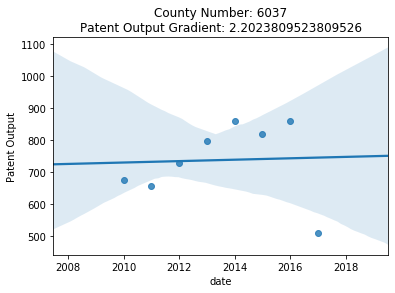

In [12]:
imported_df['date'] = imported_df['date'].str[:4]

random_county = int(imported_df.sample()['STCOU'])#provides randome county number

sample_date_df = imported_df.loc[imported_df['STCOU'] == random_county]
year_count_df=sample_date_df.groupby(['date']).size().to_frame().reset_index().astype(float)
slope, intercept, r_value, p_value, std_err = stats.linregress(year_count_df['date'],year_count_df[0])


sns.regplot(year_count_df['date'],year_count_df[0])
plt.ylabel('Patent Output')
plt.title(f"""County Number: {random_county}
Patent Output Gradient: {slope}""")

In [13]:
# # To check the name of the county
imported_df.loc[imported_df['STCOU'] == 6075].head()

,patent_id,date,title,section_id,inventor_id,city,state,it_cited,cited_by,STATEFP,...,GEOID,NAME,NAMELSAD,State ID,State Name,STCOU,Area_name,total_pop,pop_psqm,pct_2races
19413,8587862,2013,Second-harmonic generation nonliner frenquency...,G,5438251-1,680,CA,4,0,6.0,...,6.075018e+09,180.0,Census Tract 180,6,California,6075,"San Francisco, CA",805235.0,17179.1,4.7
19475,8075292,2011,Eccentric rotor compressor,F,6468045-1,174,CA,6,0,6.0,...,6.075012e+09,117.0,Census Tract 117,6,California,6075,"San Francisco, CA",805235.0,17179.1,4.7
19476,7958548,2011,Method for provision of access,H,7671321-2,388,CA,1,0,6.0,...,6.075012e+09,117.0,Census Tract 117,6,California,6075,"San Francisco, CA",805235.0,17179.1,4.7
19477,7821354,2010,Directional coupler,H,4977383-1,650,CA,9,0,6.0,...,6.075012e+09,117.0,Census Tract 117,6,California,6075,"San Francisco, CA",805235.0,17179.1,4.7
19478,9167731,2015,High voltage shielding device and a system com...,H,7994427-1,170,CA,2,0,6.0,...,6.075012e+09,117.0,Census Tract 117,6,California,6075,"San Francisco, CA",805235.0,17179.1,4.7


In [14]:
def rate_of_change(x):
    '''This fucntion takes in a county df, takes the totals of patents per year(series) 
    fits a trend line, returning a slope int'''
    #print(x)
    year_count_df=x.groupby(['date']).size().to_frame().reset_index().astype(float)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_count_df['date'],year_count_df[0])
    #print({x.iloc[0,17]},f':{slope}')
    return(slope)

In [15]:
group = imported_df.groupby(['STCOU']).apply(rate_of_change).to_frame().reset_index().rename(columns={0: 'grad_pat_output'})
# group.sort_values(by=['grad_pat_output'], ascending=False).head()

/Users/yusufsohoye/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/yusufsohoye/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/yusufsohoye/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [16]:
#Join to main dataframe
master_df = pd.merge(master_df, group, on = 'STCOU',  how='outer')
master_df.head()
#master_df.shape

,STCOU,patent_output,total_cited_by,avg_cit_pp,Area_name,total_pop,pop_psqm,pct_2races,pctle_citedby,it_cited_median,cited_by_median,grad_pat_output
0,6085,13755,28775,2.091967,"Santa Clara, CA",1781642.0,1381.0,4.9,5.0,4.0,0.0,-19.178571
1,6037,5907,10176,1.722702,"Los Angeles, CA",9818605.0,2419.6,4.5,4.0,6.0,0.0,2.202381
2,6073,5445,9663,1.774656,"San Diego, CA",3095313.0,735.8,5.1,4.0,5.0,0.0,6.607143
3,53033,4325,9820,2.270520,"King, WA",1931249.0,912.9,5.0,6.0,6.0,0.0,10.011905
4,6059,4007,9045,2.257300,"Orange, CA",3010232.0,3807.7,4.2,5.0,6.0,0.0,1.750000


In [17]:
#Reordering Columns
list(master_df.columns.values)
master_df = master_df.rename(columns={'avg_cit_pp': 'mean_cit_pp'})
master_df = master_df[['STCOU', 'Area_name', 'patent_output','grad_pat_output', 
                       'total_cited_by', 'mean_cit_pp', 'pctle_citedby', 
                       'total_pop', 'pop_psqm', 'pct_2races', ]]
master_df.head()

,STCOU,Area_name,patent_output,grad_pat_output,total_cited_by,mean_cit_pp,pctle_citedby,total_pop,pop_psqm,pct_2races
0,6085,"Santa Clara, CA",13755,-19.178571,28775,2.091967,5.0,1781642.0,1381.0,4.9
1,6037,"Los Angeles, CA",5907,2.202381,10176,1.722702,4.0,9818605.0,2419.6,4.5
2,6073,"San Diego, CA",5445,6.607143,9663,1.774656,4.0,3095313.0,735.8,5.1
3,53033,"King, WA",4325,10.011905,9820,2.270520,6.0,1931249.0,912.9,5.0
4,6059,"Orange, CA",4007,1.750000,9045,2.257300,5.0,3010232.0,3807.7,4.2


In [18]:
master_df.shape

(2382, 10)

In [19]:
master_df.to_csv ('master_df.csv', header=True, index=False)